In [1]:
import numpy as np
from numpy.random import dirichlet as Dir
from numpy.random import poisson as Poisson
import hypertools as hyp
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import brainiak.eventseg.event
from timecorr.helpers import z2r, r2z

%matplotlib inline

In [10]:
def DirichletEventTimeseries(alpha, T, D, N, L, beta):
    def get_lengths(T, N, L):
        segment_lengths = Poisson(L, [N-1])
        segment_lengths = np.divide(segment_lengths, np.sum(segment_lengths)/T)
        segment_lengths = np.round(segment_lengths).astype(int)
    
        all_scaffold_events = np.arange(N)
        while (np.sum(segment_lengths) > T) and np.any(segment_lengths > 1):        
            next_event = np.random.choice(all_scaffold_events[np.where(segment_lengths > 1)])
            segment_lengths[next_event] -= 1
    
        while np.sum(segment_lengths) < T:
            next_event = np.random.choice(all_scaffold_events)
            segment_lengths[next_event] += 1
    
        assert np.sum(segment_lengths) == T, 'failed to generate segments of the correct lengths'
        return segment_lengths
    
    def fade_between(a, b, n, beta): #fade from a to be in n steps, excluding a
        mu = np.power(np.random.uniform(size=[n]), beta)
        mu = np.sort(np.divide(mu, np.max(mu)))
        #mu = np.linspace(0, 1, n+1)[1:]
        Y = np.zeros([n, len(a)])
        for i in np.arange(n):
            Y[i, :] = np.multiply(mu[i], b) + np.multiply(1-mu[i], a)
        return Y
    
    def dirichlet_noise(x, alpha):
        a = x + alpha
        return Dir(np.divide(a, np.sum(a)))
            
    scaffold_events = np.zeros((N, D))
    for i in np.arange(N):
        scaffold_events[i, :] = Dir((alpha*np.ones((1, D))).tolist()[0])
    
    segment_lengths = get_lengths(T, N, L)          
    print(f'segment_lengths: {segment_lengths}')
        
    Y = np.zeros((T, D))
    for i in np.arange(N-1):
        start_ind = np.sum(segment_lengths[:i]) + 1
        end_ind = start_ind + segment_lengths[i] - 1
        Y[start_ind-1, :] = scaffold_events[i, :]
        Y[start_ind:end_ind, :] = fade_between(scaffold_events[i, :], scaffold_events[i+1, :], segment_lengths[i] - 1, beta)
        
    #for t in np.arange(1, T):
    #    Y[t, :] = dirichlet_noise(Y[t, :], beta)
    
    return Y

segment_lengths: [14  9 14 13]


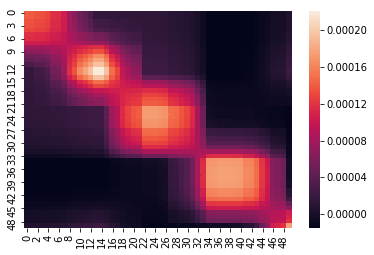

In [11]:
alpha = 0.5 #topic sparsity
beta = 2 #topic transition sharpness (higher = sharper)
T = 50 #number of timepoints
D = 100 #number of dimensions
N = 5 #number of hinge events
L = T/N #Poisson parameter; higher numbers will lead to more variable segment lengths
Y = DirichletEventTimeseries(alpha, T, D, N, L, beta)
sns.heatmap(np.cov(Y))

In [12]:
def hmm_wrapper(data, k, plot_it=False, return_model=False):
    ev = brainiak.eventseg.event.EventSegment(k)
    ev.fit(data)
    bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
    
    if plot_it:
        sns.heatmap(np.cov(data))
        ax = plt.gca()
        bounds_aug = np.concatenate(([0],bounds,[data.shape[0]]))
        for i in range(len(bounds_aug)-1):
            rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,edgecolor='w',facecolor='none')
            ax.add_patch(rect)
            
    x = np.concatenate(([0],bounds,[data.shape[0]]))
    if not return_model:
        return x
    else:
        return x, ev

In [13]:
def hmm_optimize_k(data, ks):
    def ratio_mean(corrmat, bounds):
        rs = 0.
        for i in np.arange(len(bounds)-1):
            inds = np.arange(bounds[i], bounds[i+1])
            in_event = np.min([np.mean(r2z(corrmat[inds, :][:, inds])), 1.])
            
            out_inds = np.concatenate((np.arange(bounds[i]), np.arange(bounds[i+1], data.shape[0])))
            out_event = np.mean(r2z(corrmat[inds, :][:, out_inds]))
                                                
            rs += np.divide(float(in_event), float(out_event))            
        return rs
    
    vals = np.zeros_like(ks)
    covmat = np.cov(data)
    for i in np.arange(len(ks)):
        next_bounds = hmm_wrapper(data, ks[i])
        vals[i] = ratio_mean(covmat, next_bounds)
    
    plt.plot(ks, vals, 'k')
    plt.xlabel('Number of events')
    plt.ylabel('Covariance ratio sum (in vs. out of event)')
    return ks[np.where(vals == np.max(vals))]

4 discrete events detected.


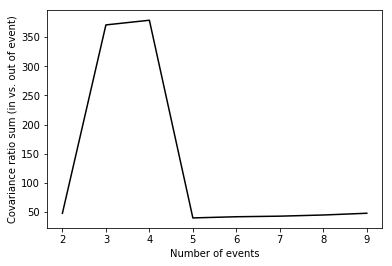

In [14]:
best_k = np.min((hmm_optimize_k(Y, np.arange(int(np.round(N/2)), int(np.round(N*2))))).astype(int))
print(f'{best_k} discrete events detected.')

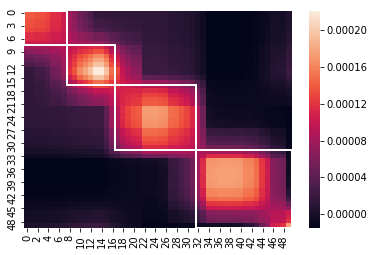

In [15]:
bounds, model = hmm_wrapper(Y, best_k, plot_it=True, return_model=True)

In [167]:
def events_plot(data, bounds):
    def bounding_box(x, border=0.1):
        minvals = np.min(x, axis=0)
        maxvals = np.max(x, axis=0)
        
        minvals -= np.multiply(border, np.abs(np.min(minvals)))
        maxvals += np.multiply(border, np.abs(np.max(maxvals)))
            
        ax = plt.plot([minvals[0], minvals[0], maxvals[0], maxvals[0], minvals[0]], [minvals[1], maxvals[1], maxvals[1], minvals[1], minvals[1]], 'k-')
        ax.set_xlim([minvals[0], maxvals[0]])
        ax.set_ylim([minvals[1], maxvals[1]])
        return ax
    
    def plot_arrows(xs, ys, color=[0.5, 0.5, 0.5]):
        def arrow(start, end, color=[0.5, 0.5, 0.5]):
            width=0.01
            head_width=0.2
            head_length=0.2
            arrow_params = {'length_includes_head': True, 'shape': 'full',
                            'head_starts_at_zero': True}
            
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], transform=plt.gca().transAxes, fc=color, ec=color, width=width, head_width=head_width, head_length=head_length, zorder=0, **arrow_params)
            
        for i in np.arange(len(xs)-1):        
            arrow(np.array([xs[i], ys[i]]), np.array([xs[i+1], ys[i+1]]))
    
    return plt.gca()
    
    def helper(x, labels, draw_bounding_box=True, size=25, linecolor=[0.5, 0.5, 0.5]):
        colors = sns.color_palette('Spectral', n_colors=len(np.unique(labels)))
        if not (linecolor is None):
            print('got here (1)')
            plot_arrows(x[:, 0], x[:, 1], color=linecolor)
            #ax = plt.plot(x[:, 0], x[:, 1], '-', color=linecolor, zorder=0)
        ax = plt.scatter(x[:, 0], x[:, 1], s=size, c=np.asarray(colors)[labels, :], zorder=1)
        if draw_bounding_box:
            print('got here (2)')
            ax = bounding_box(x)
            plt.axis('off');
        return ax
    
    event_labels = np.zeros(data.shape[0], dtype=int)
    for i in np.arange(len(bounds)-1):
        event_labels[bounds[i]:bounds[i+1]] = i
    #event_labels = model.predict(data)
    unique_labels = np.unique(event_labels)
    
    coords = hyp.reduce(data, ndims=2, reduce='SpectralEmbedding')
    
    event_coords = np.zeros([model.n_events, coords.shape[1]])
    for i in np.arange(len(unique_labels)):
        event_coords[i, :] = np.mean(coords[event_labels == unique_labels[i], :], axis=0)
    
    #plt.plot(event_coords[:, 0], event_coords[:, 1], 'k-')
    print('got here (3)')
    helper(event_coords, unique_labels, size=100, draw_bounding_box=False, linecolor=None)
    ax = helper(coords, event_labels)
    return ax
    
    
    #colors = sns.color_palette('Spectral', n_colors=len(unique_labels))
    #for i in np.arange(len(unique_labels)):
    #    inds = event_labels == unique_labels[i]
    #    plt.plot(event_coords[i, 0], event_coords[i, 1], 'o', c=colors[i], ms=10, mec='k')
        
        #plt.plot(coords[inds, 0], coords[inds, 1], 'o', c=colors[i], mec=None, ms=5)

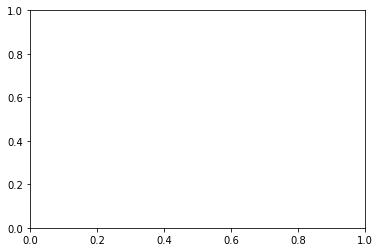

In [168]:
events_plot(Y, bounds);

In [154]:
ax.get_xlim()

(0.0, 1.0)

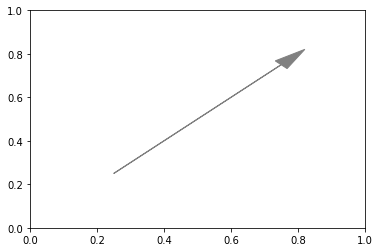

In [29]:
ax = plt.axes()
ax.arrow(0.25, 0.25, 0.5, 0.5, head_width=0.05, head_length=0.1, fc=[0.5, 0.5, 0.5], ec=[0.5, 0.5, 0.5])

In [131]:
def plot_arrows(xs, ys, color=[0.5, 0.5, 0.5]):
    def arrow(start, end, color=[0.5, 0.5, 0.5]):
        width=0.01
        head_width=0.2
        head_length=0.2
        arrow_params = {'length_includes_head': True, 'shape': 'full',
                        'head_starts_at_zero': True}
        
        plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], fc=color, ec=color, width=width, head_width=head_width, head_length=head_length, **arrow_params)
    
    for i in np.arange(len(xs)-1):        
        arrow(np.array([xs[i], ys[i]]), np.array([xs[i+1], ys[i+1]]))
    
    return plt.gca()

(-2, 2)

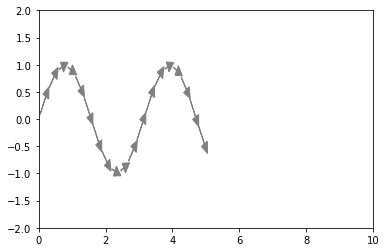

In [146]:
ax = plot_arrows(np.linspace(0, 5, 20), np.sin(np.linspace(0, 10, 20)))
ax.set_xlim([0, 10])
ax.set_ylim([-2, 2])

In [105]:
xs = np.linspace(0, 5, 20)
ys = np.sin(xs)


AttributeError: module 'matplotlib.pyplot' has no attribute 'CARETRIGHT'

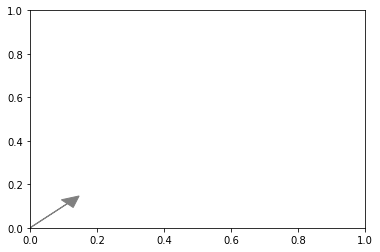

In [54]:
ax = plt.axes()
head_width = 0.05
head_length = 0.05

xs = np.linspace(0, 1, 10)
ys = np.linspace(0, 1, 10)

color = [0.5, 0.5, 0.5]

ax.arrow(xs[0], ys[0], xs[1], ys[1], head_width=head_width, head_length=head_length, fc=color, ec=color)
plt.show()

In [48]:
xs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])